In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import copy
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=10_000)
df1 = pd.read_csv('datasets/bcsc_risk_factors_expanded1.csv')
df2 = pd.read_csv('datasets/bcsc_risk_factors_expanded2.csv')
df3 = pd.read_csv('datasets/bcsc_risk_factors_expanded3.csv')
#slight cleaning
df = pd.concat([df1, df2, df3])
df = df[df.ne(9).all(1)]  #drop unknowns (9s)
df.drop(['year'], axis=1, inplace=True)


In [2]:
history_counts = df.breast_cancer_history.value_counts()
print(history_counts)
print(history_counts[1] / history_counts.sum())

breast_cancer_history
0    1161727
1      71223
Name: count, dtype: int64
0.05776633277910702


In [3]:
X = df.iloc[:, 0:df.shape[1] - 1]
y = df.iloc[:, df.shape[1] - 1]
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


In [4]:
x_df = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_df = pd.DataFrame(y_train_balanced)
x_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
y_test.reset_index(drop=True, inplace=True)

In [5]:
train_data = pd.concat([x_df, y_df], axis=1)
test_data = pd.concat([x_test_df, y_test], axis=1)
test_data

,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx,breast_cancer_history
0,2.626191,-0.577306,-0.442635,-1.341183,-0.846732,0.569867,-0.161815,0.536130,-0.052099,1.812453,0
1,2.203393,-0.577306,-0.442635,-1.341183,-0.846732,-2.023653,-0.161815,0.536130,-1.009219,-0.551738,0
2,-0.333396,0.977338,-0.442635,0.135467,-1.595376,1.866627,-0.161815,2.167084,-1.009219,-0.551738,0
3,0.512200,-0.577306,-0.442635,0.135467,1.399199,1.866627,-0.161815,0.536130,-1.009219,-0.551738,0
4,2.203393,0.200016,-0.442635,0.135467,-0.846732,0.569867,-0.161815,0.536130,-1.009219,1.812453,0
...,...,...,...,...,...,...,...,...,...,...,...
369880,-0.333396,0.200016,-0.442635,0.135467,-0.846732,0.569867,-0.161815,2.167084,0.905021,1.812453,0
369881,1.357797,-0.577306,-0.442635,1.612117,-0.846732,-0.726893,-0.161815,0.536130,-0.052099,-0.551738,0
369882,0.089402,-0.577306,-0.442635,0.135467,1.399199,0.569867,-0.161815,0.536130,0.905021,-0.551738,0
369883,0.089402,0.977338,-0.442635,0.135467,0.650555,1.866627,-0.161815,-1.094825,-1.009219,-0.551738,1


In [6]:
test_data.breast_cancer_history.value_counts()

breast_cancer_history
0    348470
1     21415
Name: count, dtype: int64

In [7]:
all_cols = df.columns.tolist()

In [8]:
# Define a custom PyTorch dataset
class Ca_Dataset(Dataset):
    def __init__(self, data):
        self.X = data[[col for col in all_cols if col != "breast_cancer_history"]].values  # Exclude target column
        self.y = data["breast_cancer_history"].values
        self.n_samples = len(data)

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.int64)

    def __len__(self):
        return self.n_samples

In [9]:
# Create PyTorch datasets and dataloaders
train_dataset = Ca_Dataset(train_data)
test_dataset = Ca_Dataset(test_data)

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=True)

In [10]:
# Define a simple neural network with one hidden layer
class Ca_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Ca_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        #self.hidden1 = nn.Linear(input_size, hidden_size)
        #self.relu1 = nn.ReLU()
        #self.hidden2 = nn.Linear(hidden_size, input_size)
        #self.relu2 = nn.ReLU()
        #self.output = nn.Linear(input_size, 1)
        #self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #x = self.relu1(self.hidden1(x))
        #x = self.relu2(self.hidden2(x))
        #x = self.sigmoid(self.output(x))
        #out = self.fc1(x)
        #out = self.relu(out)
        #out = self.fc2(out)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [15]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 10.
        self.layer_1 = nn.Linear(10, 1000) 
        self.layer_2 = nn.Linear(1000, 1000)
        self.layer_out = nn.Linear(1000, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1000)
        self.batchnorm2 = nn.BatchNorm1d(1000)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [16]:
class Deep(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Deep, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, input_size)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(input_size, hidden_size)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [17]:
# Initialize the model, loss function, and optimizer
input_size = 10 #number of features
hidden_size = 1000
num_classes = 1
learning_rate = 0.001

#model = Ca_NN(input_size, hidden_size, num_classes)
model = BinaryClassification()
#model = Deep(input_size, hidden_size)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Training loop
num_epochs = 50 
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())
        probabs = torch.sigmoid(outputs)
        out = probabs.data.round().squeeze()
        tar = targets
        loss.backward()
        optimizer.step()
        correct += torch.eq(tar, out).float().count_nonzero()
        running_loss += loss.item()
        total += targets.size(0)
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2%}")

Epoch 1/50, Loss: 0.4806, Accuracy: 77.70%
Epoch 2/50, Loss: 0.4690, Accuracy: 78.17%
Epoch 3/50, Loss: 0.4606, Accuracy: 78.59%
Epoch 4/50, Loss: 0.4534, Accuracy: 78.95%
Epoch 5/50, Loss: 0.4475, Accuracy: 79.24%
Epoch 6/50, Loss: 0.4421, Accuracy: 79.52%
Epoch 7/50, Loss: 0.4374, Accuracy: 79.78%
Epoch 8/50, Loss: 0.4336, Accuracy: 79.98%
Epoch 9/50, Loss: 0.4299, Accuracy: 80.18%
Epoch 10/50, Loss: 0.4270, Accuracy: 80.32%
Epoch 11/50, Loss: 0.4248, Accuracy: 80.44%
Epoch 12/50, Loss: 0.4226, Accuracy: 80.56%
Epoch 13/50, Loss: 0.4207, Accuracy: 80.62%
Epoch 14/50, Loss: 0.4185, Accuracy: 80.75%
Epoch 15/50, Loss: 0.4164, Accuracy: 80.83%
Epoch 16/50, Loss: 0.4151, Accuracy: 80.95%
Epoch 17/50, Loss: 0.4136, Accuracy: 80.98%
Epoch 18/50, Loss: 0.4119, Accuracy: 81.06%
Epoch 19/50, Loss: 0.4108, Accuracy: 81.15%
Epoch 20/50, Loss: 0.4096, Accuracy: 81.22%
Epoch 21/50, Loss: 0.4085, Accuracy: 81.25%
Epoch 22/50, Loss: 0.4070, Accuracy: 81.32%
Epoch 23/50, Loss: 0.4063, Accuracy: 81.3

In [19]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probabs = torch.sigmoid(outputs)
        total += targets.size(0)
        out = probabs.data.round().squeeze()
        correct += torch.eq(targets, out).float().count_nonzero()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2%}")

Accuracy on test set: 77.86%


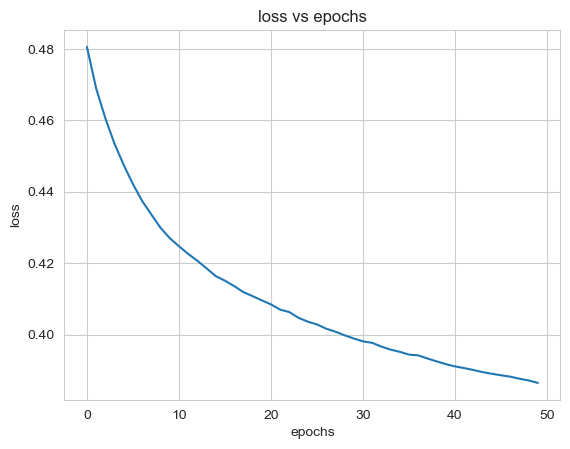

In [20]:
plt.plot(losses)
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss_vs_epochs.png')

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model_f, X_test_tensor_f, y_test_tensor_f):
    # Set the model to evaluation mode
    model_f.eval()

    # Get predictions
    with torch.no_grad():
        y_pred = model_f(X_test_tensor_f)
        y_pred = torch.sigmoid(y_pred)
        y_pred_class = y_pred.round()

    # Convert tensors to numpy arrays
    y_true = y_test_tensor_f.numpy()
    y_pred = y_pred_class.numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.show()
    plt.savefig('Confusion_Matrix.png')

    # Print classification report
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))

In [22]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87    348470
         1.0       0.18      0.77      0.29     21415

    accuracy                           0.78    369885
   macro avg       0.58      0.78      0.58    369885
weighted avg       0.94      0.78      0.84    369885



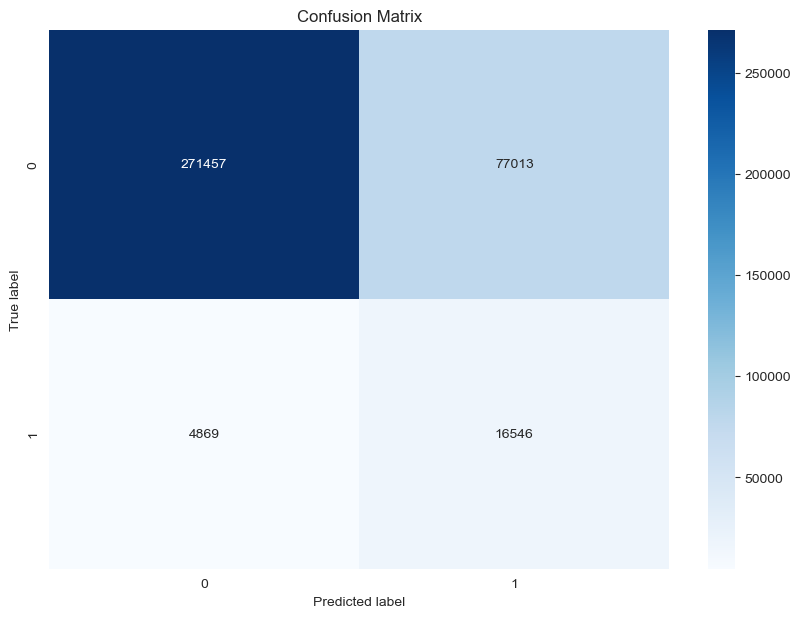

In [23]:
plot_confusion_matrix(model, X_test_tensor, y_test_tensor)